In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import itertools
import cmath
import matplotlib.pyplot as plt
import sympy


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer

def ntt_with_steps(sequence, prime, base):
    n = len(sequence)
    result = [0] * n
    steps = []
    for i in range(n):
        for j in range(n):
            result[i] += sequence[j] * pow(base, i * j, prime)
        result[i] %= prime 
        steps.append(result[:i+1])
    return result, steps



def intt_with_steps(sequence, prime, root):
    n = len(sequence)
    result = [0] * n
    steps = []
    inv_root = pow(root, prime - 2, prime)
    inv_n = pow(n, prime - 2, prime)
    for i in range(n):
        for j in range(n):
            result[i] += sequence[j] * pow(inv_root, i * j, prime)
        result[i] = (result[i] * inv_n) % prime
        steps.append(result[:i+1])  
    return result, steps

def detailed_intt_with_steps(sequence, prime, root):
    n = len(sequence)
    root_inv = pow(root, prime - 2, prime)  # Modular inverse of the root
    n_inv = pow(n, prime - 2, prime)        # Modular inverse of n

    def recursive_intt(a, depth=0):
        n = len(a)
        if n == 1:
            return a, []
        
        a_even = a[0::2]
        a_odd = a[1::2]

        y_even, steps_even = recursive_intt(a_even, depth + 1)
        y_odd, steps_odd = recursive_intt(a_odd, depth + 1)

        root_pow = pow(root_inv, (prime - 1) // n, prime)
        w = 1
        y = [0] * n
        combine_steps = []

        for k in range(n // 2):
            u = y_even[k] % prime
            t = (y_odd[k] * w) % prime
            y[k] = (u + t) % prime
            y[k + n // 2] = (u - t) % prime
            combine_steps.append([u, t, y[k], y[k + n // 2]])
            w = (w * root_pow) % prime

        # Include lower depth steps
        # combine_steps =  combine_steps
        combine_steps =  steps_even + steps_odd+ combine_steps
        return y, combine_steps

    final_result, combine_steps = recursive_intt(sequence)
    normalized_result = [(x * n_inv) % prime for x in final_result]

    combine_steps.append(final_result)
    # combine_steps.append(normalized_result)

    # Return all combined steps, raw results, and normalized results as a list
    return normalized_result, combine_steps

class NTTDataset(Dataset):
    def __init__(self, size=1000, num_bits=4, prime=17,root=3, tokenizer=None, max_length=300, used_data=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.prime = prime
        self.root = root
        self.num_bits = num_bits
        self.data = []

        while len(self.data) < size:
            seq1 = tuple(np.random.randint(0, 2, num_bits).tolist())
            seq2 = tuple(np.random.randint(0, 2, num_bits).tolist())
            if used_data is None or (seq1, seq2) not in used_data:
                self.data.append((seq1, seq2))
                if used_data is not None:
                    used_data.add((seq1, seq2))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq1, seq2 = self.data[idx]
        reversed_seq1 = seq1[::-1]
        reversed_seq2 = seq2[::-1]
        padded_seq1 = reversed_seq1 + (0,) * (32 -len(seq1))
        padded_seq2 = reversed_seq2 + (0,) * (32 - len(seq2))


        even_indices_seq = padded_seq1[0::2]
        odd_indices_seq = padded_seq1[1::2]

        even_indices_seq2 = even_indices_seq[0::2]
        odd_indices_seq2 = odd_indices_seq[1::2]

        even_indices_seq3 = even_indices_seq2[0::2]
        odd_indices_seq3 = odd_indices_seq2[1::2]

        # Calculate NTT of even and odd indices
        ntt_even = sympy.ntt(even_indices_seq, self.prime)
        ntt_odd = sympy.ntt(odd_indices_seq, self.prime)
        ntt_even2 = sympy.ntt(even_indices_seq2, self.prime)
        ntt_odd2 = sympy.ntt(odd_indices_seq2, self.prime)
        ntt_even3 = sympy.ntt(even_indices_seq3, self.prime)
        ntt_odd3 = sympy.ntt(odd_indices_seq3, self.prime)

        ntt = sympy.ntt(padded_seq1, self.prime)
        ntt2 = sympy.ntt(padded_seq2, self.prime)
        
        ntt_res1, ntt_steps1 = ntt_with_steps(padded_seq1, self.prime, self.root)
        ntt_res2, ntt_steps2 = ntt_with_steps(padded_seq2, self.prime, self.root)
        

        flattened_steps = []
        
        # flattened_steps.extend(padded_seq1)
        # flattened_steps.append(-1)
        # flattened_steps.extend(padded_seq2)
        # flattened_steps.append(-1)
        # for step1, step2 in zip(ntt_steps1, ntt_steps2):
        #     flattened_steps.extend(step1)
        #     flattened_steps.extend(step2)
        #     flattened_steps.append(-1)
        flattened_steps.append(-1)
       
        flattened_steps.extend(ntt)
        flattened_steps.append(-1)
        flattened_steps.extend(ntt2)
        flattened_steps.append(-1)
        
        last_step1 = ntt_steps1[-1]
        last_step2 = ntt_steps2[-1]


        
        flattened_steps.append(''.join(f"{i} {x} " for i, x in zip('abcdefghijklmnopqrstuvwxyz!@#$%^',ntt)) + "-1 " +
                               ''.join(f"{i} {x} " for i, x in zip('abcdefghijklmnopqrstuvwxyz!@#$%^!@#$%^', ntt2)) + "-1")
        pointwise_mult = [((a * b) % self.prime) for a, b in zip(ntt, ntt2)]
        pointwise_mult_mod = [((a * b) % self.prime) for a, b in zip(ntt, ntt2)]
        flattened_steps.append(' '.join(f"{i} {x}" for i, x in zip('abcdefghijklmnopqrstuvwxyz!@#$%^!@#$%^', pointwise_mult)))
        flattened_steps.append(-1)
        # flattened_steps.extend(pointwise_mult)
        # flattened_steps.append(-1)
        # flattened_steps.extend(pointwise_mult_mod)
        # flattened_steps.append(-1)
        
        # inverse, intt_steps = detailed_intt_with_steps(pointwise_mult, self.prime, self.root)
        # for step in intt_steps:
        #     flattened_steps.extend(step)
        #     flattened_steps.append(-1)
        inverse = sympy.intt(pointwise_mult, self.prime)

        flattened_steps.extend(inverse)
        flattened_steps.append(-1)

        result = sum([inverse[i] * 2 ** i for i in range(len(inverse))])
        binary_result = bin(result)[2:].zfill(2 * self.num_bits)

        flattened_steps.append(' '.join(f"{i}" for i in binary_result))
        flattened_steps.append(-1)
        
        combined_input = (-1,) + seq1 + (-1,) + seq2 + (-1,)
        input_text = ' '.join(map(str, combined_input))
        target_text = ' '.join(map(str, flattened_steps))

        # print(input_text)
        # print(target_text)
        
        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        targets = {k: v.squeeze() for k, v in targets.items()}
        
        inputs['labels'] = targets['input_ids']
        
        return inputs

# Initialize tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Generate data
used_data = set()
train_dataset = NTTDataset(size=5000000, num_bits=14, prime=97,root=5, tokenizer=tokenizer, max_length=340, used_data=used_data)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create OOD dataset
ood_dataset = NTTDataset(size=10000, num_bits=14, prime=97,root=5, tokenizer=tokenizer, max_length=340, used_data=used_data)
ood_dataloader = DataLoader(ood_dataset, batch_size=1, shuffle=False)

# Example usage
for batch in train_dataloader:
    print(batch['input_ids'])
    break

for batch in ood_dataloader:
    print(batch['labels'])
    break

tensor([[  0,  12, 134, 112, 112, 112, 321, 321, 112, 112, 321, 112, 112, 321,
         112, 112, 112, 111, 134, 321, 112, 321, 321, 112, 321, 112, 112, 321,
         112, 321, 112, 112, 112, 111, 134,   2,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1

In [4]:
from transformers import BartForConditionalGeneration, BartConfig
config = BartConfig(
    encoder_layers=1,
    encoder_ffn_dim=2,
    encoder_attention_heads=1,
    decoder_layers=2,
    decoder_ffn_dim=4096,
    decoder_attention_heads=2,
    d_model=1024,
)

model = BartForConditionalGeneration(config)
model.resize_token_embeddings(len(tokenizer))

Embedding(50265, 1024, padding_idx=1)

In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [6]:
def compute_metrics(eval_pred):
    total = 0
    correct = 0
    logits, labels = eval_pred

    # Get the token predictions by taking the argmax of the logits along the last dimension
    predictions = np.argmax(logits, axis=-1)
    
    # Replace -100 in labels as it is the padding index and shouldn't be counted in the accuracy
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Iterate over predictions and labels
    for pred, label in zip(predictions, labels):
        # Trim padding tokens (assuming padding token is tokenizer.pad_token_id, usually 1 or 0)
        # pred_trimmed = pred[pred != tokenizer.pad_token_id]
        # label_trimmed = label[label != tokenizer.pad_token_id]

        # # Ensure both prediction and label are of the same length after trimming
        # min_len = min(len(pred_trimmed), len(label_trimmed))
        # pred_trimmed = pred_trimmed[:min_len]
        # label_trimmed = label_trimmed[:min_len]

        # Check if the trimmed sequences match
        if np.array_equal(pred, label):
            correct += 1

        total += 1

    accuracy = correct / total if total > 0 else 0
    return {"accuracy": accuracy}

In [33]:
training_args = TrainingArguments(
    output_dir='../../../scratch/aabavandpour/14*14/results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=200,
    gradient_accumulation_steps=4,
    tf32=True,
    dataloader_num_workers=8,
    evaluation_strategy="steps",  # Evaluate every `eval_steps`
    eval_steps=200,  # How often to run evaluation
    learning_rate=0.00001
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=ood_dataset,
    # compute_metrics=compute_metrics
)

/local/aabavandpour/anaconda3/envs/Alireza/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
def calculate_accuracy(model, dataloader, tokenizer, device='cuda', max_samples=100):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            print(total)
            # Generate predictions
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=1024)
            
            # Calculate accuracy
            for output, label in zip(outputs, labels):
                # Trim padding tokens (assuming padding token is 1)
                output_trimmed = output[output != 1][1:]
                label_trimmed = label[label != 1]

                # Check if the output sequence matches the label
                if torch.equal(output_trimmed, label_trimmed):
                    correct += 1

                total += 1
                if total >= max_samples:
                    break

            if total >= max_samples:
                break

    accuracy = correct / total if total > 0 else 0
    return accuracy

# Example usage
accuracy1 = calculate_accuracy(model, ood_dataloader, tokenizer, max_samples=10000)
print(f"Accuracy: {accuracy1:.2%}")
accuracy2 = calculate_accuracy(model, train_dataloader, tokenizer, max_samples=10)
print(f"Accuracy: {accuracy2:.2%}")

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [34]:
trainer.train()

Step,Training Loss,Validation Loss
200,0.000000,0.000014
400,0.000000,0.000111
600,0.000000,0.000007


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


KeyboardInterrupt: 

In [36]:
torch.save(model.state_dict(), './models/14*14.pth')

In [ ]:
print('hello')

hello


In [19]:
import pickle

# Save the dataset to a pickle file
with open('train_dataset_14.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

In [ ]:
accuracies = []

for epoch in range(100):
    trainer.train()
    
    accuracy = calculate_accuracy(model, train_dataloader, tokenizer)
    accuracies.append((epoch + 1, accuracy))
    print(f"Epoch {epoch + 1} Accuracy: {accuracy:.2%}")

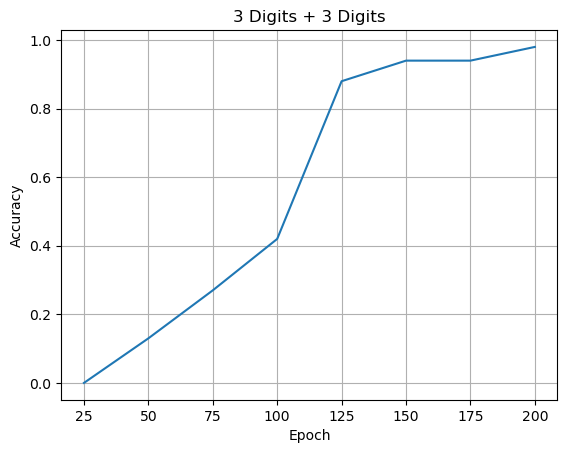

In [ ]:
epochs, acc_values = zip(*accuracies)
plt.plot([epoch * 25 for epoch in epochs], acc_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('3 Digits + 3 Digits')
plt.grid(True)
plt.show()

In [ ]:
print(epochs, acc_values)

(1, 2, 3, 4, 5, 6, 7, 8, 9) (0.0, 0.043, 0.115, 0.683, 0.905, 0.934, 0.969, 0.994, 1.0)


In [32]:
def predict_with_input(model, tokenizer, input_text, device='cuda'):
    model.eval()

    # Encode the input text
    inputs = tokenizer.encode_plus(
        input_text,
        return_tensors='pt',
        padding='max_length',  # or 'longest' depending on your use case
        max_length=1024,  # Adjust based on your model's requirements
        truncation=True
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        # Generate predictions
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=1024)
    
    # Decode the output
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

# Example usage
input_text = "1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 -1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0"
prediction = predict_with_input(model, tokenizer, input_text)
print(f"Prediction: {prediction}")

Prediction: 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 -1 5 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 -1 5 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 -1 5 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 -1 5 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 -1 5 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 -1 5 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 -1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 -1 5 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 -1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 -1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 3 1 1 1 1 1 1 1 1 

In [23]:
# Iterate through the data loader
for batch in train_dataloader:
    # Extract the input_ids and labels from the batch
    input_ids = batch['input_ids'][0]  # Get the first example in the batch
    labels = batch['labels'][0]  # Get the corresponding label

    # Decode and print the input sequence
    input_text = tokenizer.decode(input_ids, skip_special_tokens=True).strip()
    print(f"Input: {input_text}")

    # Decode and print the label sequence
    label_text = tokenizer.decode(labels, skip_special_tokens=True).strip()
    print(f"Label: {label_text}")
    
    # Break after the first example
    break


Input: 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 -1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
Label: 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 3 7 0 0 0 0 0 0 0 0 0 0 0 0 0 3 10 7 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 3 7 1 0 0 0 0 0 0 0 0 0 0 0 0 3 10 7 15 0 0 0 0 0 0 0 0 0 0 0 0 -1 5 3 7 1 1 0 0 0 0 0 0 0 0 0 0 0 3 10 7 15 4 0 0 0 0 0 0 0 0 0 0 0 -1 5 3 7 1 1 3 0 0 0 0 0 0 0 0 0 0 3 10 7 15 4 13 0 0 0 0 0 0 0 0 0 0 -1 5 3 7 1 1 3 10 0 0 0 0 0 0 0 0 0 3 10 7 15 4 13 5 0 0 0 0 0 0 0 0 0 -1 5 3 7 1 1 3 10 4 0 0 0 0 0 0 0 0 3 10 7 15 4 13 5 12 0 0 0 0 0 0 0 0 -1 5 3 7 1 1 3 10 4 1 0 0 0 0 0 0 0 3 10 7 15 4 13 5 12 1 0 0 0 0 0 0 0 -1 5 3 7 1 1 3 10 4 1 9 0 0 0 0 0 0 3 10 7 15 4 13 5 12 1 5 0 0 0 0 0 0 -1 5 3 7 1 1 3 10 4 1 9 2 0 0 0 0 0 3 10 7 15 4 13 5 12 1 5 3 0 0 0 0 0 -1 5 3 7 1 1 3 10 4 1 9 2 5 0 0 0 0 3 10 7 15 4 13 5 12 1 5 3 5 0 0 0 0 -1 5 3 7 1 1 3 10 4 1 9 2 5 1 0 0 0 3 10 7 15 4 13 5 12 1 5 3 5 13 0 0 0 -1 5 3 

In [10]:
def input_in_dataloader(input_text, dataloader, tokenizer):
    for batch in dataloader:
        for input_ids in batch['input_ids']:
            decoded_data = tokenizer.decode(input_ids, skip_special_tokens=True).strip()
            print(f"Decoded: '{decoded_data}' | Input: '{input_text}'")
            if decoded_data == input_text:
                return True
    return False

# Ensure dataloader is not shuffled
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Example usage
input_text = "0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0"
exists = input_in_dataloader(input_text, train_dataloader, tokenizer)
print(f"Input is in dataset: {exists}")

Decoded: '0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 -1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 -1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 -1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 -1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 -1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 -1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 -1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded: '0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 -1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0' | Input: '0 1 1 1 0 0 0 0 -1 1 0 1 0 0 0 0 0'
Decoded:

KeyboardInterrupt: 

In [ ]:
model.to('cpu')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [ ]:
import torch
import numpy as np

def binary_multiplication(model, tokenizer, bin_a, bin_b):
    model.eval()
    
    # Pad binary numbers (assuming pad_binary is a defined function)
    padded_a = pad_binary(bin_a)
    padded_b = pad_binary(bin_b)
    
    # Compute FFT with depth information (assuming these functions are defined)
    fft_number1, tree_dict1 = compute_fft_with_tree(padded_a)
    fft_number2, tree_dict2 = compute_fft_with_tree(padded_b)
    
    # Compute the convolution of the FFTs
    multiplication = np.multiply(fft_number1, fft_number2)
    
    # Compute iFFT with depth information
    inverse, ifft_tree_dict = compute_ifft_with_tree(multiplication)
    inverse = np.array(inverse).real.round().astype(int)
    
    # Prepare depth columns for FFT1
    fft1_depth_text = ""
    max_depth1 = max(k[0] for k in tree_dict1.keys())
    for depth in range(max_depth1, -1, -1):
        nodes = [np.round(tree_dict1.get((depth, i), []), 2).tolist() for i in range(2**depth)]
        fft1_depth_text += f", FFT1_depth_{depth}: {nodes}"
    
    # Prepare depth columns for FFT2
    fft2_depth_text = ""
    max_depth2 = max(k[0] for k in tree_dict2.keys())
    for depth in range(max_depth2, -1, -1):
        nodes = [np.round(tree_dict2.get((depth, i), []), 2).tolist() for i in range(2**depth)]
        fft2_depth_text += f", FFT2_depth_{depth}: {nodes}"
    
    # Prepare depth columns for iFFT
    ifft_depth_text = ""
    max_depth_ifft = max(k[0] for k in ifft_tree_dict.keys())
    for depth in range(max_depth_ifft, -1, -1):
        nodes = [np.round(ifft_tree_dict.get((depth, i), []), 2).tolist() for i in range(2**depth)]
        ifft_depth_text += f", ifft_depth_{depth}: {nodes}"
    
    # Construct the input text
    input_text = (
            f"{bin_a}, "
            f"{bin_b}, "
        )
    
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=MAX_LENGTH, padding='max_length', truncation=True)
    input_ids = inputs['input_ids'].to('cuda')
    attention_mask = inputs['attention_mask'].to('cuda')
    
    # Generate the output text
    with torch.no_grad():
        beam_output = model.generate(input_ids, attention_mask = attention_mask, max_length=512, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
        output = tokenizer.decode(beam_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True) 
    
    return output

# Example
bin_a = 11000000
bin_b = 11010000
result = binary_multiplication(model, tokenizer, bin_a, bin_b)
print(f"{bin_a} * {bin_b} = {result}")

11000000 * 11010000 = 110010000


In [ ]:
model_path = "../temp/t5_base_model_without_FFT.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)
print(f"T5 model saved to {model_path}")

T5 model saved to ../temp/t5_base_model_without_FFT.pth


In [ ]:
def generate_test_examples_from_df(dataframe):
    examples = []
    for _, row in dataframe.iterrows():
        bin_a = row['First Number']
        bin_b = row['Second Number']
        examples.append((bin_a, bin_b))
    return examples

def compute_ground_truth(bin_a, bin_b):
    int_a = int(bin_a, 2)
    int_b = int(bin_b, 2)
    result = int_a + int_b
    return bin(result)[2:]  # Convert to binary string and remove '0b' prefix

def calculate_accuracy(model, tokenizer, test_examples):
    correct_predictions = 0
    
    for bin_a, bin_b in test_examples:
        predicted_result = binary_multiplication(model, tokenizer, bin_a, bin_b)
    
        if predicted_result != '00000000':
            predicted_result = predicted_result.lstrip('0')
        else:
            predicted_result = '0'
        predicted_result = predicted_result.rstrip(' ')
        ground_truth = compute_ground_truth(bin_a, bin_b)    
        print(bin_a, bin_b, predicted_result, ground_truth)   

        # Compare the predicted result with the ground truth
        if predicted_result == ground_truth:
            correct_predictions += 1
    
    accuracy = correct_predictions / len(test_examples)
    return accuracy

# Example usage
test_examples = generate_test_examples_from_df(dataset_df.sample(n=100, random_state=42))  # Generate 100 test examples
accuracy = calculate_accuracy(model, tokenizer, test_examples)
print(f"Model accuracy: {accuracy * 100:.2f}%")

11110110 10010111 110001100 110001101
10100000 10001111 100101111 100101111
00001111 10010101 10100001 10100100
10010001 01011101 11100011 11101110
01110111 11001001 101000011 101000000
10111100 01101010 100101100 100100110
00111111 01100111 10100001 10100110
11000110 10011111 101100111 101100101
00000011 10101000 10110001 10101011
11111000 00001111 11111111 100000111
01011011 00110100 1110111 10001111
00111000 11100100 100011101 100011100
11111101 01000010 100111111 100111111
11011001 00110100 100001111 100001101
01001101 11111001 101001000 101000110
01110000 10111001 100101111 100101001
00111001 00001011 111111 1000100
00111100 11110011 100110000 100101111
10011111 10011011 100111111 100111010
01100110 01101001 11001111 11001111
01001110 00100111 1110111 1110101
10000000 00001111 10001111 10001111
01111011 01110110 10111111 11110001
11001000 10111000 110000100 110000000
00100100 01010010 1111100 1110110
00111001 11011011 100001101 100010100
01011100 10111010 100010111 100010110
00110

In [ ]:
import pandas as pd
import random

def generate_unique_test_examples_with_results(dataframe, num_examples=100):
    existing_pairs = set(zip(dataframe['First Number'], dataframe['Second Number']))
    examples = []

    while len(examples) < num_examples:
        bin_a = format(random.randint(0, 15), '04b')  # Generate random 4-bit binary number
        bin_b = format(random.randint(0, 15), '04b')
        if (bin_a, bin_b) not in existing_pairs:
            result = compute_ground_truth(bin_a, bin_b)
            examples.append((bin_a, bin_b))
            existing_pairs.add((bin_a, bin_b))  # Ensure uniqueness

    return examples

# Generate unique test examples with results
unique_test_examples = generate_unique_test_examples_with_results(dataset_df, num_examples=100)

# Convert to DataFrame
# test_df = pd.DataFrame(unique_test_examples, columns=['First Number', 'Second Number', 'Final Result'])

accuracy = calculate_accuracy(model, tokenizer, unique_test_examples)
print(f"Model accuracy: {accuracy * 100:.2f}%")


KeyboardInterrupt: 